In [17]:
# ===========================
# IMPORTS AND CONFIGURATION
# ===========================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from scipy import stats
import zipfile
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# ===========================
# DATA LOADING AND PREPROCESSING
# ===========================

# Unzip dataset
print("Extracting dataset...")
with zipfile.ZipFile("OBD-II-Dataset.zip", "r") as zip_ref:
    zip_ref.extractall("Dataset/")

def load_and_preprocess_data(path_csv_jam, path_csv_normal, path_csv_free):
    """Load and preprocess the OBD-II dataset"""
    
    # Load individual datasets
    df_jam = pd.read_csv(path_csv_jam)
    df_normal = pd.read_csv(path_csv_normal)
    df_free = pd.read_csv(path_csv_free)
    
    # Add traffic state labels
    df_jam["traffic_state"] = "traffic_jam"
    df_normal["traffic_state"] = "normal_traffic"
    df_free["traffic_state"] = "traffic_free"
    
    # Combine datasets
    df = pd.concat([df_jam, df_normal, df_free], ignore_index=True)
    
    return df

def time_to_seconds(time_str):
    """Convert time string to seconds"""
    h, m, s = map(float, time_str.split(":"))
    return h * 3600 + m * 60 + s

def calculate_derivatives(df):
    """Calculate speed and pedal derivatives"""
    # Convert time to seconds and handle missing values
    df["Time_sec"] = df["Time"].apply(time_to_seconds)
    df.ffill(inplace=True)
    
    # Calculate time differences
    dt = df["Time_sec"].diff().replace(0, np.nan).fillna(0.1)
    
    # Calculate derivatives
    speed_mps = df["Vehicle Speed Sensor [km/h]"] / 3.6
    speed_accel = speed_mps.diff() / dt  # m/s²
    pedal_rate = df["Accelerator Pedal Position D [%]"].diff() / dt  # % per second
    
    df["speed_accel"] = speed_accel
    df["pedal_rate"] = pedal_rate
    
    return df

def detect_events(df):
    """Detect sudden acceleration and braking events - ADJUSTED VERSION"""
    # More conservative thresholds
    df["sudden_accel"] = ((df["pedal_rate"] > 25) | (df["speed_accel"] > 3.0)).astype(int)
    df["sudden_brake"] = ((df["speed_accel"] < -4.0) | (df["pedal_rate"] < -20)).astype(int)
    return df

def enhance_features(df):
    """Add advanced feature engineering"""
    # Rolling statistics for temporal patterns
    window_size = 10
    
    # Speed features
    df['speed_std'] = df['Vehicle Speed Sensor [km/h]'].rolling(window_size, min_periods=1).std()
    df['speed_rolling_mean'] = df['Vehicle Speed Sensor [km/h]'].rolling(window_size, min_periods=1).mean()
    
    # RPM features
    df['rpm_std'] = df['Engine RPM [RPM]'].rolling(window_size, min_periods=1).std()
    df['rpm_rolling_mean'] = df['Engine RPM [RPM]'].rolling(window_size, min_periods=1).mean()
    
    # Throttle features
    df['throttle_std'] = df['Absolute Throttle Position [%]'].rolling(window_size, min_periods=1).std()
    
    # Engine load indicator
    df['engine_load'] = (df['Engine RPM [RPM]'] * df['Absolute Throttle Position [%]']) / 1000
    
    # Jerk (rate of change of acceleration)
    df['jerk'] = df['speed_accel'].diff() / df['Time_sec'].diff().replace(0, 0.1)
    
    # Fill NaN values
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    
    return df

Extracting dataset...


In [19]:
# ===========================
# WINDOW PROCESSING
# ===========================

def extract_window_features(window):
    """Extract comprehensive features from a time window"""
    row = {}
    
    if len(window) == 0:
        return None
    
    # Basic statistics
    row.update({
        'rpm_mean': window['Engine RPM [RPM]'].mean(),
        'rpm_std': window['Engine RPM [RPM]'].std(),
        'rpm_max': window['Engine RPM [RPM]'].max(),
        'speed_mean': window['Vehicle Speed Sensor [km/h]'].mean(),
        'speed_std': window['Vehicle Speed Sensor [km/h]'].std(),
        'speed_max': window['Vehicle Speed Sensor [km/h]'].max(),
        'throttle_mean': window['Absolute Throttle Position [%]'].mean(),
        'throttle_std': window['Absolute Throttle Position [%]'].std(),
        'maf_mean': window['Air Flow Rate from Mass Flow Sensor [g/s]'].mean(),
        'maf_std': window['Air Flow Rate from Mass Flow Sensor [g/s]'].std(),
    })
    
    # Acceleration features
    row.update({
        'accel_mean': window['speed_accel'].mean(),
        'accel_std': window['speed_accel'].std(),
        'accel_max': window['speed_accel'].max(),
        'accel_min': window['speed_accel'].min(),
        'pedal_rate_mean': window['pedal_rate'].mean(),
        'pedal_rate_std': window['pedal_rate'].std(),
    })
    
    # Advanced statistical features
    if len(window) > 5:
        try:
            row['speed_entropy'] = stats.entropy(
                np.histogram(window['Vehicle Speed Sensor [km/h]'], bins=5)[0] + 1e-6
            )
            row['rpm_entropy'] = stats.entropy(
                np.histogram(window['Engine RPM [RPM]'], bins=5)[0] + 1e-6
            )
        except:
            row['speed_entropy'] = 0
            row['rpm_entropy'] = 0
    else:
        row['speed_entropy'] = 0
        row['rpm_entropy'] = 0
    
    # Event counts
    row.update({
        'accel_events': window['sudden_accel'].sum(),
        'brake_events': window['sudden_brake'].sum(),
        'total_events': window['sudden_accel'].sum() + window['sudden_brake'].sum(),
    })
    
    # Engine load features
    row.update({
        'engine_load_mean': window['engine_load'].mean(),
        'engine_load_std': window['engine_load'].std(),
    })
    
    # Fuel efficiency metrics (only when moving)
    moving_mask = window['Vehicle Speed Sensor [km/h]'] > 5
    if moving_mask.any():
        row['moving_efficiency'] = (
            window.loc[moving_mask, 'Engine RPM [RPM]'].mean() *
            window.loc[moving_mask, 'Absolute Throttle Position [%]'].mean() /
            (window.loc[moving_mask, 'Air Flow Rate from Mass Flow Sensor [g/s]'].mean() + 1e-3)
        )
        row['moving_ratio'] = moving_mask.sum() / len(window)
    else:
        row['moving_efficiency'] = 0
        row['moving_ratio'] = 0
    
    # Traffic state
    row['traffic_state'] = window['traffic_state'].iloc[0]
    
    return row

def create_sliding_windows(df, window_size=15.0, step_size=7.5):
    """Create sliding windows from the time series data"""
    start_time = df["Time_sec"].min()
    end_time = df["Time_sec"].max()
    
    windows = []
    current_time = start_time
    
    print("Creating sliding windows...")
    with tqdm(total=int((end_time - start_time - window_size) / step_size) + 1) as pbar:
        while current_time + window_size <= end_time:
            window_data = df[
                (df["Time_sec"] >= current_time) & 
                (df["Time_sec"] < current_time + window_size)
            ]
            
            if len(window_data) >= 5:  # Minimum samples per window
                windows.append(window_data)
            
            current_time += step_size
            pbar.update(1)
    
    return windows

def create_feature_dataset(windows):
    """Create feature dataset from windows"""
    rows = []
    
    print("Extracting window features...")
    for window in tqdm(windows):
        features = extract_window_features(window)
        if features is not None:
            rows.append(features)
    
    df_features = pd.DataFrame(rows)
    
    # Encode traffic state
    traffic_map = {'traffic_free': 0, 'normal_traffic': 1, 'traffic_jam': 2}
    df_features['traffic_state_num'] = df_features['traffic_state'].map(traffic_map)
    
    return df_features

def label_driving_styles(df_features):
    """Label driving styles based on features"""
    # Eco-labeling based on fuel efficiency
    eff_threshold = np.percentile(df_features['moving_efficiency'], 33)
    df_features['eco_score'] = (df_features['moving_efficiency'] <= eff_threshold).astype(int)
    
    # Hybrid driving style labeling
    def assign_driving_style(row):
        # Aggressive if high event count or high acceleration variability
        if (row['total_events'] > 0 or 
            row['accel_std'] > 1.5 or 
            row['rpm_std'] > 500):
            return "aggressive"
        # Calm if eco-friendly and low speed
        elif (row['eco_score'] == 1 and 
              row['speed_mean'] < 40 and 
              row['accel_std'] < 0.5):
            return "calm"
        else:
            return "normal"
    
    df_features['driving_style'] = df_features.apply(assign_driving_style, axis=1)
    
    return df_features


In [20]:
# ===========================
# NEURAL NETWORK MODEL
# ===========================

class EnhancedDrivingNet(nn.Module):
    """Enhanced neural network for driving style classification"""
    
    def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32], dropout_rate=0.3):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers with batch normalization and dropout
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 3))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

class DrivingDataset(Dataset):
    """PyTorch Dataset for driving style data"""
    
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


In [21]:
import copy
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score


def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    total = 0
    for batch_features, batch_labels in loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_features.size(0)
        total += batch_features.size(0)

    return running_loss / max(1, total)


def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_features, batch_labels in loader:
            batch_features = batch_features.to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels.to(device))
            running_loss += loss.item() * batch_features.size(0)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(batch_labels.numpy())

    avg_loss = running_loss / max(1, len(loader.dataset))
    accuracy = accuracy_score(all_true, all_preds) if len(all_true) > 0 else 0.0
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, epochs=50, patience=10, lr=1e-3):
    """Train the model and keep a deepcopy of the best full model (not only state dict).

    Returns training history (list of dicts).
    """
    import copy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')
    best_model = None
    best_model_info = {}

    training_history = []
    patience_counter = 0

    print("Starting training...")
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = validate_epoch(model, val_loader, criterion)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save a deepcopy of the complete model (full object)
            best_model = copy.deepcopy(model)
            best_model_info = {'epoch': epoch, 'val_loss': val_loss, 'val_accuracy': val_accuracy}
        else:
            patience_counter += 1

        training_history.append({'epoch': epoch + 1, 'train_loss': train_loss, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1:3d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # If we have a best model copy, replace model with it
    if best_model is not None:
        model = best_model
        print(f"Loaded best model from epoch {best_model_info.get('epoch')} (val_loss={best_model_info.get('val_loss'):.4f})")
    else:
        print("No best model recorded; returning final model")

    return training_history

def evaluate_model(model, test_loader):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_probs = []
    all_true = []
    
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features = batch_features.to(device)
            outputs = model(batch_features)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_true.extend(batch_labels.numpy())
    
    # Convert back to original labels
    style_mapping = {0: "calm", 1: "normal", 2: "aggressive"}
    pred_labels = [style_mapping[p] for p in all_preds]
    true_labels = [style_mapping[p] for p in all_true]
    
    # Calculate metrics
    accuracy = accuracy_score(all_true, all_preds)
    
    print("\n" + "="*50)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, target_names=['calm', 'normal', 'aggressive']))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(true_labels, pred_labels, labels=['calm', 'normal', 'aggressive'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['calm', 'normal', 'aggressive'],
                yticklabels=['calm', 'normal', 'aggressive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_probs, all_preds, all_true


In [22]:
# ===========================
# EXPORTER AND LOADER
# ===========================
import json
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

def save_scaler_to_json(scaler, filepath):
    """Save StandardScaler to JSON file"""
    scaler_data = {
        'mean': scaler.mean_.tolist(),
        'scale': scaler.scale_.tolist(),
        'var': scaler.var_.tolist() if hasattr(scaler, 'var_') else None,
        'n_samples_seen': int(scaler.n_samples_seen_)  # Convert to native Python int
    }
    
    with open(filepath, 'w') as f:
        json.dump(scaler_data, f, indent=2)

def load_scaler_from_json(filepath):
    """Load StandardScaler from JSON file"""
    with open(filepath, 'r') as f:
        scaler_data = json.load(f)
    
    scaler = StandardScaler()
    
    # Reconstruct the scaler state
    scaler.n_samples_seen_ = scaler_data['n_samples_seen']
    
    # Set the internal attributes
    scaler.mean_ = np.array(scaler_data['mean'])
    scaler.scale_ = np.array(scaler_data['scale'])
    
    if scaler_data['var'] is not None:
        scaler.var_ = np.array(scaler_data['var'])
    
    return scaler

def save_label_encoder_to_json(encoder, filepath):
    """Save LabelEncoder to JSON file"""
    encoder_data = {
        'classes': encoder.classes_.tolist()
    }
    
    with open(filepath, 'w') as f:
        json.dump(encoder_data, f, indent=2)

def load_label_encoder_from_json(filepath):
    """Load LabelEncoder from JSON file"""
    with open(filepath, 'r') as f:
        encoder_data = json.load(f)
    
    encoder = LabelEncoder()
    encoder.classes_ = np.array(encoder_data['classes'])
    
    return encoder

Step 1: Loading and preprocessing data...

Step 2: Creating sliding windows...
Creating sliding windows...


100%|██████████| 6360/6360 [00:03<00:00, 2079.07it/s]


Extracting window features...


100%|██████████| 2084/2084 [00:03<00:00, 568.17it/s]



Step 3: Preparing features and labels...

Saving preprocessing objects...

Step 4: Splitting data...

Step 5: Creating data loaders...

Step 6: Training model...
Starting training...
Epoch  10: Train Loss: 0.1353, Val Loss: 0.0822, Val Acc: 0.9760
Epoch  20: Train Loss: 0.1035, Val Loss: 0.0613, Val Acc: 0.9760
Epoch  30: Train Loss: 0.0939, Val Loss: 0.0410, Val Acc: 0.9880
Epoch  40: Train Loss: 0.0785, Val Loss: 0.0374, Val Acc: 0.9820
Epoch  50: Train Loss: 0.0655, Val Loss: 0.0370, Val Acc: 0.9880
Epoch  60: Train Loss: 0.0683, Val Loss: 0.0354, Val Acc: 0.9850
Epoch  70: Train Loss: 0.0550, Val Loss: 0.0297, Val Acc: 0.9880
Early stopping at epoch 70
Loaded best model from epoch 54 (val_loss=0.0296)

Step 7: Evaluating model...

COMPREHENSIVE MODEL EVALUATION
Overall Accuracy: 0.9904

Classification Report:
              precision    recall  f1-score   support

        calm       1.00      0.83      0.91        12
      normal       0.99      0.99      0.99       368
  aggressiv

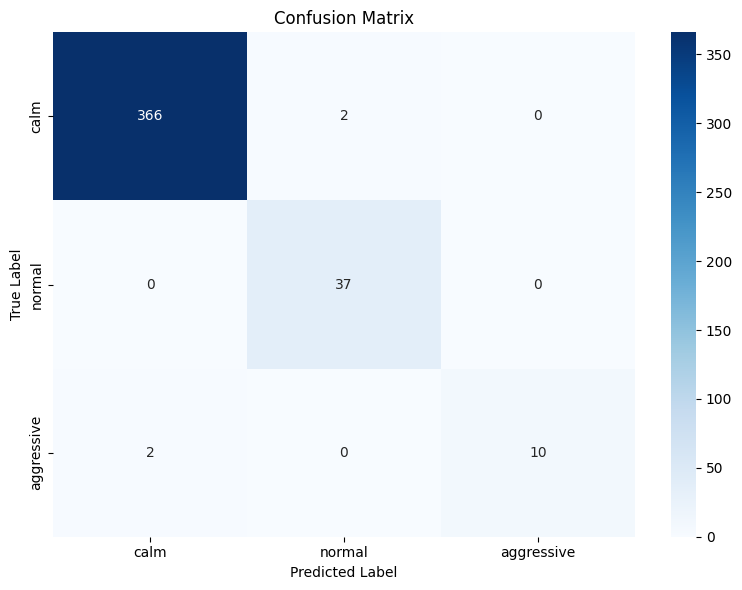


Step 8: Saving models...
✓ Safe complete model saved successfully
✓ Complete model saved successfully

✅ Training completed! Final test accuracy: 0.9904

Saved models and files:
  - driving_model_state_dict.pth (state dict + metadata)
  - safe_complete_model.pth (safe complete model for PyTorch 2.6+)
  - complete_driving_model.pth (complete model)
  - feature_scaler.json
  - label_encoder.json


In [23]:
# ===========================
# MAIN EXECUTION
# ===========================

def main():
    """Main execution function - FIXED VERSION"""

    # 1. Load and preprocess data
    print("Step 1: Loading and preprocessing data...")
    df = load_and_preprocess_data(
        "./Dataset/OBD-II-Dataset/2018-03-29_Seat_Leon_KA_RT_Stau.csv",
        "./Dataset/OBD-II-Dataset/2018-04-23_Seat_Leon_RT_KA_Normal.csv",
        "./Dataset/OBD-II-Dataset/2018-04-23_Seat_Leon_KA_KA_Frei.csv"
    )
    df = calculate_derivatives(df)
    df = detect_events(df)
    df = enhance_features(df)

    # 2. Create sliding windows and extract features
    print("\nStep 2: Creating sliding windows...")
    windows = create_sliding_windows(df, window_size=15.0, step_size=7.5)
    df_features = create_feature_dataset(windows)
    df_features = label_driving_styles(df_features)

    # 3. Prepare features and labels
    print("\nStep 3: Preparing features and labels...")
    feature_columns = [
        'rpm_mean', 'rpm_std', 'rpm_max', 
        'speed_mean', 'speed_std', 'speed_max',
        'throttle_mean', 'throttle_std',
        'maf_mean', 'maf_std',
        'accel_mean', 'accel_std', 'accel_max', 'accel_min',
        'pedal_rate_mean', 'pedal_rate_std',
        'speed_entropy', 'rpm_entropy',
        'accel_events', 'brake_events', 'total_events',
        'engine_load_mean', 'engine_load_std',
        'moving_efficiency', 'moving_ratio',
        'traffic_state_num', 'eco_score'
    ]

    X = df_features[feature_columns].values
    y = df_features['driving_style'].values

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Save preprocessing objects as JSON
    print("\nSaving preprocessing objects...")
    save_scaler_to_json(scaler, 'feature_scaler.json')
    save_label_encoder_to_json(label_encoder, 'label_encoder.json')

    # 4. Split data
    print("\nStep 4: Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    # 5. Create data loaders
    print("\nStep 5: Creating data loaders...")
    train_dataset = DrivingDataset(X_train, y_train)
    val_dataset = DrivingDataset(X_val, y_val)
    test_dataset = DrivingDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 6. Initialize and train model
    print("\nStep 6: Training model...")
    input_dim = X_train.shape[1]
    model = EnhancedDrivingNet(input_dim=input_dim).to(device)

    training_history = train_model(
        model, train_loader, val_loader, epochs=100, patience=15
    )

    # 7. Evaluate model
    print("\nStep 7: Evaluating model...")
    accuracy, probabilities, predictions, true_labels = evaluate_model(model, test_loader)

    # 8. Save final model (multiple formats for compatibility)
    print("\nStep 8: Saving models...")

    # Option 1: Save state dict (most compatible)
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_dim': input_dim,
        'feature_columns': feature_columns,
        'training_history': training_history
    }, 'driving_model_state_dict.pth')

    # Option 2: Save complete model with safe_globals (for PyTorch 2.6+)
    try:
        import torch.serialization as ts
        with ts.safe_globals([EnhancedDrivingNet]):
            torch.save(model, 'safe_complete_model.pth')
        print("✓ Safe complete model saved successfully")
    except Exception as e:
        print(f"⚠️  Safe complete model saving failed: {e}")
        print("✓ Falling back to state dict only")

    # Option 3: Save complete model directly (legacy compatibility)
    try:
        torch.save(model, 'complete_driving_model.pth')
        print("✓ Complete model saved successfully")
    except Exception as e:
        print(f"⚠️  Complete model saving failed: {e}")

    print(f"\n✅ Training completed! Final test accuracy: {accuracy:.4f}")
    print("\nSaved models and files:")
    print("  - driving_model_state_dict.pth (state dict + metadata)")
    print("  - safe_complete_model.pth (safe complete model for PyTorch 2.6+)")
    print("  - complete_driving_model.pth (complete model)")
    print("  - feature_scaler.json")
    print("  - label_encoder.json")

# Updated prediction function that works with the new format
def predict_driving_style_updated(df):
    """Updated prediction function that works with new model format"""
    
    # 1. Load dependencies
    scaler = load_scaler_from_json('feature_scaler.json')
    
    # Preprocess the data
    df = calculate_derivatives(df)
    df = detect_events(df)
    df = enhance_features(df)
    
    # 2. Create sliding windows and extract features
    print("Creating sliding windows and extracting features...")
    windows = create_sliding_windows(df, window_size=15.0, step_size=7.5)
    df_features = create_feature_dataset(windows)
    
    # 3. Prepare features
    feature_columns = [
        'rpm_mean', 'rpm_std', 'rpm_max', 
        'speed_mean', 'speed_std', 'speed_max',
        'throttle_mean', 'throttle_std',
        'maf_mean', 'maf_std',
        'accel_mean', 'accel_std', 'accel_max', 'accel_min',
        'pedal_rate_mean', 'pedal_rate_std',
        'speed_entropy', 'rpm_entropy',
        'accel_events', 'brake_events', 'total_events',
        'engine_load_mean', 'engine_load_std',
        'moving_efficiency', 'moving_ratio',
        'traffic_state_num', 'eco_score'
    ]

    X = df_features[feature_columns].values
    X_scaled = scaler.transform(X)
    
    # 4. Load model and predict
    print("Loading model and making predictions...")
    
    # Try to load safe complete model first, fall back to state dict
    try:
        # Try safe complete model
        model = torch.load('safe_complete_model.pth', map_location='cpu')
        print("✓ Loaded safe complete model")
    except:
        try:
            # Try complete model
            model = torch.load('complete_driving_model.pth', map_location='cpu')
            print("✓ Loaded complete model")
        except:
            # Fall back to state dict
            checkpoint = torch.load('driving_model_state_dict.pth', map_location='cpu')
            input_dim = checkpoint['input_dim']
            model = EnhancedDrivingNet(input_dim=input_dim)
            model.load_state_dict(checkpoint['model_state_dict'])
            print("✓ Loaded model from state dict")
    
    model.eval()
    
    with torch.no_grad():
        predictions = model(torch.FloatTensor(X_scaled))
        predicted_classes = torch.argmax(predictions, dim=1)
    
    # 5. Return results
    style_mapping = {0: "calm", 1: "normal", 2: "aggressive"}
    results = [style_mapping[p] for p in predicted_classes.numpy()]
    
    return results

if __name__ == "__main__":
    main()
